In [1]:
# Colab was used for this notebook hence the library installs
%%capture
!pip install pycaret --quiet --upgrade
!pip install dabl --quiet --upgrade
!pip install shap --quiet --upgrade
!pip install sdv  --quiet --upgrade
!pip install sdv[ctgan] --quiet --upgrade
!pip install baytune --quiet --upgrade
!pip install optuna --quiet --upgrade

UsageError: Line magic function `%%capture` not found.


## **Why this was done**
1. Learn about synthetic data generation and see if it can improve a model
2. Work with PyCaret on a classification problem
3. Work on an insurance related problem (although ficticious data)

## **The data**
Insurance data isn't easy to find given the nature of the data. However there are [fictious data](https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset) around which class of amount of the insurance given data below.

* ` age `
* ` bmi `
* ` children `
* ` sex `
* ` smoker `
* ` region `

The target value is 0, 1, 2, 3 such that higher number represents a higher range of insurance. 

The amount of data for each target value is approximately the same.

Throughout the dataset, we are using **GTGAN**

# **Libraries**

In [2]:
from pycaret.classification import * 
#from pycaret.regression import * # Preprocessing, modelling, interpretation, deployment...
from sklearn.impute import SimpleImputer
import pandas as pd # Basic data manipulation
#import dabl as db # Summary plot
from sklearn.model_selection import train_test_split # Data split
from sdv.tabular import CopulaGAN, GaussianCopula, CTGAN # Synthetic data
from sdv.evaluation import evaluate # Evaluate synthetic data
#from btb.tuning import Tunable, GCPTuner # CopulaGAN optimising
#from btb.tuning import hyperparams as hp  # Set hyperparameters for optimising
import joblib # Saving preparation steps
import sdv.constraints as cons # Evaluate synthetic data

# **Importing data**

In [3]:
# Read and output the top 5 rows
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head()

,age,sex,bmi,children,smoker,region,charges
0,59,female,27.72,3,no,southeast,2
1,60,male,25.74,0,no,southeast,2
2,28,female,34.77,0,no,northwest,0
3,19,female,28.40,1,no,southwest,0
4,45,male,27.50,3,no,southwest,1


We first transform the regression problem into a classification problem. We split the data with respect to four quantiles. Therefore, the number of for each label of charges is roughly the same..

A fairly simply ordering per feature. 


Now feature(s) can be initialised
* Target feature
* Continuous features
* Ordinal features
* Categorical features
* Features to ignore

In [3]:
# Target feature
target = "charges"

# Continuous/numeric features
cont_feats = ["age", "bmi"]

# Ordinal features
ord_feats = {"children" : ["0", "1", "2", "3", "4", "5"]}

# Categorical geatures
cat_feats = ["region", "smoker", "sex"]

# There is a value error for children:
# ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than.


# **Generating synthetic data, Round one** 
# **Naive Generating**
There's a useful library `sdev` [Synthetic Data Generation](https://github.com/sdv-dev/SDV) to generate synthetic tabular data. I've played around with it specifically the `CopulaGAN` model.

Also we have constaints for the models to make data reasonable.

In [4]:
def MAXINT(a,b): return (abs(a-b)+(a+b))//2

def MAX(a,b): return (abs(a-b)+(a+b))/2

def MININT(a,b): return (-abs(a-b)+(a+b))//2

def MIN(a,b): return (-abs(a-b)+(a+b))/2

def over_18(data): return MAXINT(data["age"],18)

age_constraint = cons.ColumnFormula(column = 'age',
                                    formula = over_18,
                                    handling_strategy = 'reject_sampling')

def children_range(data): return MININT(MAXINT(data["children"],0),5)

children_constraint = cons.ColumnFormula(column = 'children',
                                         formula = children_range,
                                         handling_strategy = 'reject_sampling')

min_bmi = min(train["bmi"])
max_bmi = max(train["bmi"])

def bmi_range(data): return MIN(MAX(data["bmi"],min_bmi),max_bmi)

bmi_constraint = cons.ColumnFormula(column = 'bmi',
                                    formula = bmi_range,
                                    handling_strategy = 'reject_sampling')

min_charges= min(train["charges"])
max_charges = max(train["charges"])

def charges_range(data): return MIN(MAX(data["charges"],min_charges*0.8),max_charges*1.25)

charges_constraint = cons.ColumnFormula(column = 'charges',
                                    formula = charges_range,
                                    handling_strategy = 'reject_sampling')

def charges_range_truncated(data): return MIN(MAX(data["charges"],12000),max_charges*1.25)

charges_constraint_2 = cons.ColumnFormula(column = 'charges',
                                    formula = charges_range_truncated,
                                    handling_strategy = 'reject_sampling')

In [15]:
import time
best_score = 0 # Keep track of best score
best_data = None
tracker = 0 # Keep track of how many loops have completed
flag = True
scores=[]

real = train # Filter to only those employees that left
ST=time.time()
## TRAINING LOOP START ##
for _ in range(30): # only 1 and do the test

    # Increment the tracker
    tracker += 1
  
    # Every 5 loops output the tracker -> 1 loop
    print(tracker)

    # Get the hyperparameters for this loop
    #proposal = tuner.propose(1)
  
    # Create the CopulaGAN -> GAussianCopu;a
    # NOTE - batch_size is multiplied by 10 as needs to be a factor of 10
    model = CTGAN(constraints = [age_constraint, children_constraint, bmi_constraint])
    
    
    # Fit the CTGAN
    model.fit(real)
    metadata = model.get_metadata()
    # Create 600 rows of data
    synth_data = model.sample(num_rows = 600)
  
    # Evaluate the synthetic data against the real data
    score = evaluate(synthetic_data = synth_data, real_data = real)
    scores.append(score)

    print(score)
    # If the new hyperparameters beat the best ones, store them along with the score
    if score > best_score or flag:
        flag = False
        best_data = synth_data
        #best_params = proposal
        best_score = score
  


## TRAINING LOOP END ##
ED=time.time()
print((ED-ST)/60,"minutes")

1
0.517530395769619
2
0.54286483606782
3
0.4704839216703378
4
0.5320142789788114
5
0.5873381224232475
6
0.5079675158280081
7
0.6245083569326447
8
0.5547897956944443
9
0.5666320652715531
10
0.5168888801234545
11
0.5459954116321376
12
0.5652240214617968
13
0.5381531526153849
14
0.5906126703299632
15
0.5065770341539354
16
0.4671060493404616
17
0.5194009507031594
18
0.5183546428672006
19
0.4868014672644876
20
0.548558269186043
21
0.5992960367657593
22
0.509667810363542
23
0.5900180513383445
24
0.525447536022312
25
0.513574476499147
26
0.5794797395787946
27
0.48576701559910185
28
0.5436748664932662
29
0.5905501620840881
30
0.6258383007935253
16.849698781967163 minutes


In [19]:
score = evaluate(synthetic_data = best_data, real_data = real, aggregate = False)
score

,metric,name,raw_score,normalized_score,min_value,max_value,goal
0,BNLogLikelihood,BayesianNetwork Log Likelihood,-2.707691,0.066691,-inf,0.0,MAXIMIZE
1,LogisticDetection,LogisticRegression Detection,0.847824,0.847824,0.0,1.0,MAXIMIZE
2,SVCDetection,SVC Detection,0.357076,0.357076,0.0,1.0,MAXIMIZE
11,GMLogLikelihood,GaussianMixture Log Likelihood,-7783.543390,0.000000,-inf,inf,MAXIMIZE
12,CSTest,Chi-Squared,0.929030,0.929030,0.0,1.0,MAXIMIZE
13,KSTest,Inverted Kolmogorov-Smirnov D statistic,0.885673,0.885673,0.0,1.0,MAXIMIZE
14,KSTestExtended,Inverted Kolmogorov-Smirnov D statistic,0.914575,0.914575,0.0,1.0,MAXIMIZE
27,ContinuousKLDivergence,Continuous Kullback–Leibler Divergence,0.597741,0.597741,0.0,1.0,MAXIMIZE
28,DiscreteKLDivergence,Discrete Kullback–Leibler Divergence,0.979954,0.979954,0.0,1.0,MAXIMIZE


In [20]:
score['normalized_score'].mean()

0.6198405326620611

In [21]:
score = evaluate(synthetic_data = best_data, real_data = real, aggregate = True)
score

0.6228623772468773

In [22]:
print(max(scores))
print(min(scores))

0.6258383007935253
0.4671060493404616


In [23]:
model.save('best_copula.pkl')

In [24]:
synth_data.to_csv("ins_synth_data_classifier_CTGAN.csv", index = False)

So after 75 loops the overall score is 0.81 (this score is between 0 and 1) for 600 synthetic examples of Attrition = "Yes" so it's not too bad.

```
Best score obtained:  0.8127129012858366
Best parameters:  {'epochs': 208, 'batch_size': 42, 'embedding_dim': 10, 'gen': 54, 'dim_gen': 788}
```

# **Setting up data for round 2**
The real dataset can be split into 60:40 training/test. Once this has been split the synthetic data can be added to the training data. This in a way doesn't "waste" the real dataset in the training.

In [25]:
# Load synth data in
synth_data = pd.read_csv("ins_synth_data_classifier_CTGAN.csv")

# Add the 600 synthetic rows of data to training data + remove dataset column
mixed = pd.concat([train, synth_data])

In [26]:
synth_data

,age,sex,bmi,children,smoker,region,charges
0,19,female,32.004795,1,no,northeast,2
1,25,male,34.343756,3,no,northeast,0
2,27,male,17.627243,0,no,northwest,0
3,42,female,26.326390,1,yes,northeast,2
4,21,female,33.072533,0,no,northwest,2
...,...,...,...,...,...,...,...
595,39,male,16.472209,1,no,southwest,1
596,24,female,36.063175,0,no,southwest,2
597,38,male,23.537587,0,no,northwest,0
598,66,female,36.294481,0,yes,northwest,3


In [40]:
print("Training size (real):", train.shape)
print("Training size (fake + real):", mixed.shape)
print("Testing size (real:", test.shape)

Training size (real): (802, 7)
Training size (fake + real): (1402, 7)
Testing size (real: (536, 7)


In [41]:
ord_feats = {"children" : list("012345")}

The ratio of the synthetic data of charge >14000 is 0.0000


(array([127.,  99., 203., 171.]),
 array([0, 1, 2, 3, 4]),
 <a list of 4 Patch objects>)

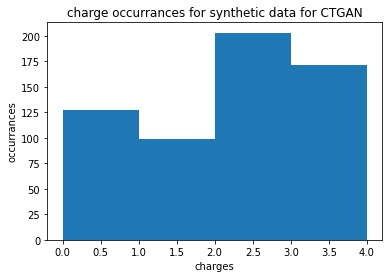

In [45]:
from matplotlib import pyplot as plt
#num_bins = 20
#group = [1000*i for i in range(13,65)]
#plt.hist(synth_data["charges"], group)
total01=len(synth_data["charges"])
ans01=[]
for i in range(0,4):
    num=len(synth_data["charges"][synth_data["charges"]==i])
    ans01.append(num/total01)
ans01=np.array(ans01)
print("The ratio of the synthetic data of charge >14000 is %.4f"%sum(ans01[14:]))
plt.title("charge occurrances for synthetic data for CTGAN")
plt.xlabel("charges")
plt.ylabel("occurrances")
plt.hist(synth_data["charges"],bins=[i for i in range (5)])

The ratio of the original data of charge >14000 is 0.0000


(array([331., 334., 338., 335.]),
 array([0, 1, 2, 3, 4]),
 <a list of 4 Patch objects>)

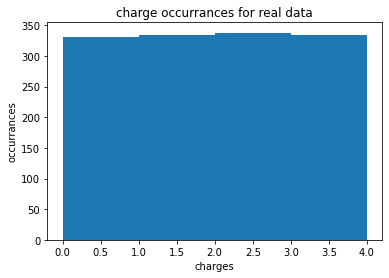

In [44]:
#plt.hist(ins_data["charges"][ins_data["charges"]>13000], group)
total02=len(ins_data["charges"])
ans02 = []
for i in range(4):
    num=len(ins_data["charges"][ins_data["charges"]==i])
    ans02.append(num/total02)
ans02=np.array(ans02)
print("The ratio of the original data of charge >14000 is %.4f"%sum(ans02[14:]))
plt.title("charge occurrances for real data")
plt.xlabel("charges")
plt.ylabel("occurrances")
plt.hist(ins_data["charges"],bins=[i for i in range (5)])

Now this data can be fed into a new `setup` but this time declaring `test_data` as the test data that was created earlier. 

So there is a combination of **synthetic and real data in the training set** but only real in the test data.

In [31]:
# Run pycaret setup w/synthetic data
setup(data = mixed, 
      target = target, 
      test_data = test,
      train_size = 0.7, 
      numeric_features = cont_feats,
      categorical_features = cat_feats,
      ordinal_features = ord_feats,
      normalize_method = "zscore",
      ignore_low_variance = True,
      silent = True, verbose = False)

(False,
 [],
 Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['region', 'smoker',
                                                             'sex'],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['age', 'bmi'],
                                       target='charges', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fil...
                 ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                 ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                 ('cluster_all', 'passthrough'),
                 ('dummy', Dum

Now setup the `compare_models` can be checked again. Interestingly the `AUC`, `Recall` and `Precision` all went up considerably. `Recall` nearly doubled!

In [32]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.5681,0.7387,0.5750,0.5708,0.5621,0.4249,0.4285,0.1420
nb,Naive Bayes,0.5632,0.7266,0.5714,0.5717,0.5578,0.4193,0.4238,0.0130
ada,Ada Boost Classifier,0.5468,0.7127,0.5560,0.5533,0.5380,0.3978,0.4032,0.0350
rf,Random Forest Classifier,0.5440,0.7362,0.5465,0.5442,0.5403,0.3898,0.3915,0.1350
lda,Linear Discriminant Analysis,0.5275,0.7174,0.5192,0.5438,0.5124,0.3641,0.3745,0.0120
lr,Logistic Regression,0.5247,0.7184,0.5166,0.5376,0.5094,0.3601,0.3696,0.6350
lightgbm,Light Gradient Boosting Machine,0.5168,0.7251,0.5211,0.5140,0.5120,0.3536,0.3551,0.1020
ridge,Ridge Classifier,0.5139,0.0000,0.5017,0.5355,0.4869,0.3443,0.3584,0.0100
et,Extra Trees Classifier,0.4926,0.7148,0.4950,0.4935,0.4890,0.3205,0.3222,0.1300
knn,K Neighbors Classifier,0.4292,0.6423,0.4413,0.4127,0.4056,0.2419,0.2483,0.2570


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=8251, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

A gradient boosting classifier was decided upon.

In [33]:
gbr = create_model("gbr")

ValueError: Estimator gbr not available. Please see docstring for list of available estimators.

# **SECOND TRIAL**, NORMALIZED, CTGAN

With the tuner ready it's as simple as creating a training loop and then calling the tuner within the loop and feeding the hyperparameters into the CopulaGAN.

In [47]:
best_score = 0 # Keep track of best score
# best_params=None
best_data = None
tracker = 0 # Keep track of how many loops have completed
flag = True
scores=[]

real = train # Filter to only those employees that left

import time
ST=time.time()

## TRAINING LOOP START ##
for _ in range(30): # only 1 and do the test

    # Increment the tracker
    tracker += 1
  
    # Every 5 loops output the tracker -> 1 loop
    print(tracker)



    # Record the hyperparameters and score      
    # proposal = tuner.propose(1)
  
    # NOTE - batch_size is multiplied by 10 as needs to be a factor of 10
    #model = GaussianCopula(constraints = [age_constraint, children_constraint, bmi_constraint, charges_constraint])
    model = CTGAN(constraints = [age_constraint, children_constraint, bmi_constraint])
    
    # Fit the CopulaGAN
    model.fit(real)
    # Create 600 rows of data
    synth_data = model.sample(num_rows = 1500)
  
    # Evaluate the synthetic data against the real data
    score = evaluate(synthetic_data = synth_data, real_data = real)
    scores.append(score)

    print(score)
    # If the new hyperparameters beat the best ones, store them along with the score
    if score > best_score or flag:
        flag = False
        best_data = synth_data
        best_distributions = model.get_metadata()
        # best_params = proposal
        best_score = score
  
    # Record the hyperparameters and score      
    # tuner.record(proposal, score)


## TRAINING LOOP END ##
ED=time.time()
print("time used: %.3f mins"%((ED-ST)/60))

1
0.6076206966131981
2
0.5307706198526146
3
0.5797588419025321
4
0.5847498133251797
5
0.5526589282632077
6
0.5231345182856469
7
0.6163051252698383
8
0.5303918604298796
9
0.60923524674779
10
0.5272947845933302
11
0.48967752869330816
12
0.5202509842680806
13
0.5092132563852821
14
0.4974668956892072
15
0.5901217864723879
16
0.5457851774855222
17
0.5748963682136949
18
0.5698776556709042
19
0.4947090455701988
20
0.5467565525613746
21
0.53906209319371
22
0.5351850063914206
23
0.4773706857625631
24
0.5903635369943213
25
0.549789022666425
26
0.5490720531426432
27
0.5565416969723788
28
0.4983728787318187
29
0.536294738416431
30
0.6073714082702716
time used: 15.212 mins


In [48]:
best_data

,age,sex,bmi,children,smoker,region,charges
4,38,female,21.483792,0,no,northwest,2
10,51,female,25.114976,2,no,northeast,2
11,70,male,36.092220,2,no,southeast,0
12,52,male,28.603943,2,no,northwest,3
13,22,male,20.601148,3,no,southeast,2
...,...,...,...,...,...,...,...
151,21,male,25.682687,0,yes,southwest,2
154,33,female,34.799731,0,no,southwest,1
0,38,male,28.971140,0,yes,northwest,2
3,65,female,36.007410,2,no,southeast,1


In [49]:
best_distributions

Table(name=None, field_names=['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'])

In [50]:
score = evaluate(synthetic_data = best_data, real_data = real, aggregate = False)
score

,metric,name,raw_score,normalized_score,min_value,max_value,goal
0,BNLogLikelihood,BayesianNetwork Log Likelihood,-2.708744,0.066620,-inf,0.0,MAXIMIZE
1,LogisticDetection,LogisticRegression Detection,0.739221,0.739221,0.0,1.0,MAXIMIZE
2,SVCDetection,SVC Detection,0.384098,0.384098,0.0,1.0,MAXIMIZE
11,GMLogLikelihood,GaussianMixture Log Likelihood,-7.943689,0.000355,-inf,inf,MAXIMIZE
12,CSTest,Chi-Squared,0.938659,0.938659,0.0,1.0,MAXIMIZE
13,KSTest,Inverted Kolmogorov-Smirnov D statistic,0.878156,0.878156,0.0,1.0,MAXIMIZE
14,KSTestExtended,Inverted Kolmogorov-Smirnov D statistic,0.912589,0.912589,0.0,1.0,MAXIMIZE
27,ContinuousKLDivergence,Continuous Kullback–Leibler Divergence,0.641129,0.641129,0.0,1.0,MAXIMIZE
28,DiscreteKLDivergence,Discrete Kullback–Leibler Divergence,0.974848,0.974848,0.0,1.0,MAXIMIZE


In [51]:
synth=[]
for i in range (4):
    synth_part=best_data[best_data["charges"]==i]
    generate=synth_part[:150]
    synth.append(generate)
synth=pd.concat(synth)
synth.sample(frac=1)

,age,sex,bmi,children,smoker,region,charges
959,44,male,33.004656,0,yes,southwest,2
215,59,female,16.208794,1,no,southwest,1
544,60,male,16.453765,2,yes,southwest,1
518,41,male,33.029557,0,no,northeast,1
1336,29,male,41.023829,0,no,southeast,3
...,...,...,...,...,...,...,...
523,30,female,26.785369,0,no,northwest,1
89,51,female,21.908735,0,yes,northeast,1
1125,59,female,17.637575,2,no,southeast,0
1313,32,female,33.573031,0,no,southeast,3


In [52]:
score = evaluate(synthetic_data = synth, real_data = train, aggregate = True)
score

0.6145385141803834

In [53]:
print('Best score obtained: ', best_score)

Best score obtained:  0.6163051252698383


In [54]:
print(max(scores))
print(min(scores))

0.6163051252698383
0.4773706857625631


In [55]:
model.save('best_copula.pkl')

In [56]:
synth.to_csv("ins_synth_norm_CTGAN.csv", index = False)

# **Setting up data for round 2**
The real dataset can be split into 60:40 training/test. Once this has been split the synthetic data can be added to the training data. This in a way doesn't "waste" the real dataset in the training.

In [57]:
# Load synth data in
synth_data2 = pd.read_csv("ins_synth_norm_CTGAN.csv")

# Add the 600 synthetic rows of data to training data + remove dataset column
mixed = pd.concat([train, synth_data2])

In [58]:
mixed

,age,sex,bmi,children,smoker,region,charges
25,59,female,27.720000,3,no,southeast,2
336,60,male,25.740000,0,no,southeast,2
47,28,female,34.770000,0,no,northwest,0
106,19,female,28.400000,1,no,southwest,0
1269,45,male,27.500000,3,no,southwest,1
...,...,...,...,...,...,...,...
595,45,male,22.664946,0,no,southeast,3
596,47,female,21.738607,0,no,northeast,3
597,58,male,38.349281,1,no,northwest,3
598,26,female,17.934647,0,yes,southwest,3


In [59]:
print("Training size (real):", train.shape)
print("Training size (fake + real):", mixed.shape)
print("Testing size (real:", test.shape)

Training size (real): (802, 7)
Training size (fake + real): (1402, 7)
Testing size (real: (536, 7)


Now this data can be fed into a new `setup` but this time declaring `test_data` as the test data that was created earlier. 

So there is a combination of **synthetic and real data in the training set** but only real in the test data.

In [60]:
# Run pycaret setup w/synthetic data
setup(data = mixed, 
      target = "charges", 
      test_data = test,
      train_size = 0.7, 
      numeric_features = cont_feats,
      categorical_features = cat_feats,
      ordinal_features = ord_feats,
      normalize_method = "zscore",
      ignore_low_variance = True,
      silent = True, verbose = False)

(False,
 [],
 Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['region', 'smoker',
                                                             'sex'],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['age', 'bmi'],
                                       target='charges', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fil...
                 ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                 ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                 ('cluster_all', 'passthrough'),
                 ('dummy', Dum

Now setup the `compare_models` can be checked again. Interestingly the `AUC`, `Recall` and `Precision` all went up considerably. `Recall` nearly doubled!

In [61]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.5645,0.7439,0.5644,0.5657,0.5629,0.4191,0.4201,0.1350
ada,Ada Boost Classifier,0.5524,0.7255,0.5525,0.5630,0.5502,0.4031,0.4071,0.0330
lr,Logistic Regression,0.5396,0.7210,0.5399,0.5434,0.5359,0.3862,0.3882,0.5620
lda,Linear Discriminant Analysis,0.5382,0.7218,0.5386,0.5417,0.5344,0.3843,0.3864,0.0110
nb,Naive Bayes,0.5375,0.7224,0.5377,0.5442,0.5363,0.3833,0.3852,0.0120
ridge,Ridge Classifier,0.5254,0.0000,0.5260,0.5292,0.5188,0.3675,0.3705,0.0100
lightgbm,Light Gradient Boosting Machine,0.5211,0.7297,0.5209,0.5204,0.5185,0.3610,0.3616,0.0690
rf,Random Forest Classifier,0.5168,0.7263,0.5167,0.5152,0.5132,0.3555,0.3567,0.1460
et,Extra Trees Classifier,0.4790,0.6962,0.4789,0.4781,0.4761,0.3051,0.3058,0.1320
qda,Quadratic Discriminant Analysis,0.4306,0.6441,0.4305,0.4382,0.4224,0.2405,0.2438,0.0120


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=8500, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

A gradient boosting classifier was decided upon.

In [141]:
par = create_model("par")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,10954.8805,143387712.5698,11974.4608,0.1995,0.9926,1.6671
1,9159.9032,103898711.5317,10193.0717,0.2458,0.8758,1.3109
2,8642.4571,98509753.0295,9925.2080,0.1533,0.8381,1.1994
3,6037.1063,98821511.4717,9940.9009,0.1665,0.6844,0.5700
4,5841.8495,122188292.2400,11053.8813,0.2626,0.6121,0.3460
5,7272.8044,130572913.1729,11426.8505,-0.0651,1.0492,0.6452
6,9428.8647,109644020.8651,10471.1041,-24.0453,1.4358,0.5739
7,11221.1583,160140846.3472,12654.6769,-28.1558,1.2325,0.4962
8,14925.8786,263586325.6491,16235.3419,-25.3092,0.7947,0.4559
9,24723.0391,677586546.7186,26030.4926,-15.9813,0.9026,0.5400


# **Finalising the model**
Now with the model trained and evaluated it needs to be **finalised**. This encorporates the test data into the model that will be used on unseen data.

# **SECOND TRIAL**, CTGAN, NORMALIZED, CF

With the tuner ready it's as simple as creating a training loop and then calling the tuner within the loop and feeding the hyperparameters into the CopulaGAN.

In [63]:
train

,age,sex,bmi,children,smoker,region,charges
25,59,female,27.720,3,no,southeast,2
336,60,male,25.740,0,no,southeast,2
47,28,female,34.770,0,no,northwest,0
106,19,female,28.400,1,no,southwest,0
1269,45,male,27.500,3,no,southwest,1
...,...,...,...,...,...,...,...
1095,18,female,31.350,4,no,northeast,0
1130,39,female,23.870,5,no,southeast,1
1294,58,male,25.175,0,no,northeast,2
860,37,female,47.600,2,yes,southwest,3


In [64]:
best_score = 0 # Keep track of best score
# best_params=None
best_data = None
tracker = 0 # Keep track of how many loops have completed
flag = True
scores=[]

real = train # Filter to only those employees that left

import time
ST=time.time()

## TRAINING LOOP START ##
for _ in range(30): # only 1 and do the test

    # Increment the tracker
    tracker += 1
  
    # Every 5 loops output the tracker -> 1 loop
    print(tracker)



    # Record the hyperparameters and score      
    # proposal = tuner.propose(1)
  
    # NOTE - batch_size is multiplied by 10 as needs to be a factor of 10
    #model = GaussianCopula(constraints = [age_constraint, children_constraint, bmi_constraint, charges_constraint])
    model = CTGAN(constraints = [age_constraint, children_constraint, bmi_constraint],
                 field_transformers = {k:"categorical_fuzzy" for k in ["sex", "smoker", "region"]})
    
    # Fit the CopulaGAN
    model.fit(real)
    # Create 600 rows of data
    synth_data = model.sample(num_rows = 1500)
  
    # Evaluate the synthetic data against the real data
    score = evaluate(synthetic_data = synth_data, real_data = real)
    scores.append(score)

    print(score)
    # If the new hyperparameters beat the best ones, store them along with the score
    if score > best_score or flag:
        flag = False
        best_data = synth_data
        best_distributions = model.get_metadata()
        # best_params = proposal
        best_score = score
  
    # Record the hyperparameters and score      
    # tuner.record(proposal, score)


## TRAINING LOOP END ##
ED=time.time()
print("time used: %.3f mins"%((ED-ST)/60))

1
0.6075350875269713
2
0.5946411058104877
3
0.5963715694693916
4
0.5152040261684078
5
0.4703151777429271
6
0.5224395464540031
7
0.5785145459734446
8
0.499025616329389
9
0.5737810751218584
10
0.5395666982395452
11
0.5560722907250724
12
0.5795890232781058
13
0.49241108509679066
14
0.5853693991656898
15
0.5481548792142203
16
0.5600808082311994
17
0.5662026628301503
18
0.5764718320916452
19
0.6223288755773981
20
0.4956559369848329
21
0.5573555279947169
22
0.543066301636314
23
0.5414339252580778
24
0.5312212433170924
25
0.4868202214366996
26
0.5677525909562227
27
0.458594234106087
28
0.554811925591657
29
0.5448379484942858
30
0.6107358331601808
time used: 406.942 mins


In [124]:
best_data

,age,sex,bmi,children,smoker,region,charges
14,27,male,32.837885,0,no,southeast,15098.067776
36,42,male,32.895858,0,no,southwest,19632.656325
95,35,male,26.343561,2,yes,southeast,21473.364623
162,45,female,32.807978,2,no,northeast,20782.406939
195,57,female,40.871721,1,no,northwest,55298.535815
...,...,...,...,...,...,...,...
208,43,male,34.549504,2,no,northeast,13859.031224
224,49,female,33.320707,1,no,southeast,16431.975611
230,66,female,40.998620,1,yes,southwest,68270.410366
239,56,male,26.863160,1,no,northwest,46876.677980


In [125]:
best_distributions

{'age': 'copulas.univariate.gaussian_kde.GaussianKDE',
 'sex': 'copulas.univariate.uniform.UniformUnivariate',
 'bmi': 'copulas.univariate.gamma.GammaUnivariate',
 'children': 'copulas.univariate.gaussian_kde.GaussianKDE',
 'smoker': 'copulas.univariate.gamma.GammaUnivariate',
 'region': 'copulas.univariate.beta.BetaUnivariate',
 'charges': 'copulas.univariate.gamma.GammaUnivariate'}

(array([ 0.,  0.,  0.,  0.,  0.,  0., 42., 33., 49., 48., 48., 37., 26.,
        24., 23., 19., 32., 28., 41., 20., 12., 16., 14., 16., 11.,  9.,
         3.,  7.,  5.,  4.,  2.,  0.]),
 array([    0,  2000,  4000,  6000,  8000, 10000, 12000, 14000, 16000,
        18000, 20000, 22000, 24000, 26000, 28000, 30000, 32000, 34000,
        36000, 38000, 40000, 42000, 44000, 46000, 48000, 50000, 52000,
        54000, 56000, 58000, 60000, 62000, 64000]),
 <a list of 32 Patch objects>)

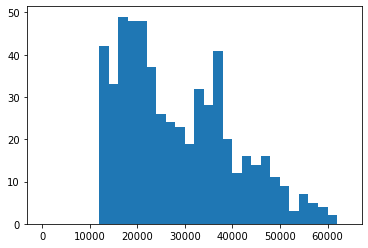

In [126]:
best=best_data
best_data=best_data[~best_data.index.duplicated()]
num_bins = 20
plt.hist(best_data["charges"], [2000*i for i in range (33)])

In [127]:
score = evaluate(synthetic_data = best_data, real_data = real, aggregate = False)
score

,metric,name,raw_score,normalized_score,min_value,max_value,goal
0,BNLogLikelihood,BayesianNetwork Log Likelihood,-2.573633,7.625803e-02,-inf,0.0,MAXIMIZE
1,LogisticDetection,LogisticRegression Detection,0.275467,2.754669e-01,0.0,1.0,MAXIMIZE
2,SVCDetection,SVC Detection,0.168154,1.681539e-01,0.0,1.0,MAXIMIZE
11,GMLogLikelihood,GaussianMixture Log Likelihood,-27.302078,1.389499e-12,-inf,inf,MAXIMIZE
12,CSTest,Chi-Squared,0.972720,9.727195e-01,0.0,1.0,MAXIMIZE
13,KSTest,Inverted Kolmogorov-Smirnov D statistic,0.689213,6.892129e-01,0.0,1.0,MAXIMIZE
14,KSTestExtended,Inverted Kolmogorov-Smirnov D statistic,0.810748,8.107476e-01,0.0,1.0,MAXIMIZE
27,ContinuousKLDivergence,Continuous Kullback–Leibler Divergence,0.471065,4.710653e-01,0.0,1.0,MAXIMIZE
28,DiscreteKLDivergence,Discrete Kullback–Leibler Divergence,0.991951,9.919505e-01,0.0,1.0,MAXIMIZE


In [128]:
synth=[]
for i in range (6,32):
    orig_size=len(train[train["charges"]<(i+1)*2000][train["charges"]>(i)*2000])
    synth_part=best_data[best_data["charges"]<(i+1)*2000][best_data["charges"]>(i)*2000]
    generate=synth_part[:100-orig_size]
    synth.append(generate)
synth=pd.concat(synth)
synth.sample(frac=1)

,age,sex,bmi,children,smoker,region,charges
453,59,female,34.958217,2,no,southeast,37864.063160
2285,38,female,43.457786,2,no,southeast,34582.587535
904,24,male,37.099197,0,yes,southeast,16604.249491
694,56,male,43.825160,4,no,northeast,23478.043542
992,42,male,39.426590,2,no,southeast,30058.785690
...,...,...,...,...,...,...,...
5362,41,male,35.428771,0,yes,southeast,28433.511697
2207,55,male,32.214894,3,no,northwest,24835.994764
5650,55,male,29.162773,2,no,southwest,55926.936669
3169,62,female,36.485118,1,no,northeast,28348.594427


In [129]:
score = evaluate(synthetic_data = synth, real_data = train, aggregate = True)
score

0.4957809904397932

In [130]:
print('Best score obtained: ', best_score)

Best score obtained:  0.49667550181398695


In [131]:
print(max(scores))
print(min(scores))

0.49667550181398695
0.4609102292740649


In [132]:
model.save('best_copula.pkl')

In [133]:
synth.to_csv("ins_synth_dat_univariate.csv", index = False)

# **Setting up data for round 2**
The real dataset can be split into 60:40 training/test. Once this has been split the synthetic data can be added to the training data. This in a way doesn't "waste" the real dataset in the training.

In [134]:
# Load synth data in
synth_data2 = pd.read_csv("ins_synth_dat_univariate.csv")

# Add the 600 synthetic rows of data to training data + remove dataset column
mixed = pd.concat([train, synth_data2])

In [135]:
mixed

,age,sex,bmi,children,smoker,region,charges
25,59,female,27.720000,3,no,southeast,14001.133800
336,60,male,25.740000,0,no,southeast,12142.578600
47,28,female,34.770000,0,no,northwest,3556.922300
106,19,female,28.400000,1,no,southwest,2331.519000
1269,45,male,27.500000,3,no,southwest,8615.300000
...,...,...,...,...,...,...,...
564,51,male,35.650971,4,no,southeast,58430.623129
565,59,male,33.125002,0,no,southeast,58379.194286
566,67,female,25.072104,1,yes,southwest,58984.566472
567,65,female,44.251790,3,no,southeast,60091.739335


In [136]:
print("Training size (real):", train.shape)
print("Training size (fake + real):", mixed.shape)
print("Testing size (real:", test.shape)

Training size (real): (802, 7)
Training size (fake + real): (1371, 7)
Testing size (real: (536, 7)


(array([ 0., 54., 56., 47., 54., 38., 47., 44., 47., 32., 39., 51., 48.,
        46., 39., 24., 34., 37., 40., 35., 38., 32., 25., 21., 23., 19.,
        19., 19., 16., 14., 15.,  9., 14., 24., 23., 16., 25., 32., 13.,
        17., 12., 11., 16.,  6.,  9., 11., 13., 15.,  9.,  7.,  5.,  5.,
         4.,  0.,  3.,  5.,  3.,  2.,  4.,  1.,  3.,  0.,  1.,  0.]),
 array([    0,  1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,
         9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000,
        18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000,
        27000, 28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000,
        36000, 37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000,
        45000, 46000, 47000, 48000, 49000, 50000, 51000, 52000, 53000,
        54000, 55000, 56000, 57000, 58000, 59000, 60000, 61000, 62000,
        63000, 64000]),
 <a list of 64 Patch objects>)

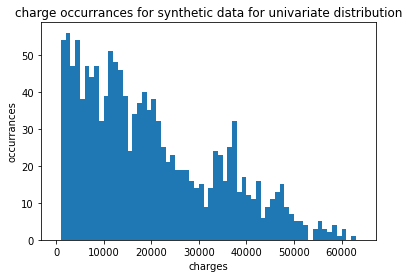

In [137]:
#plt.hist(synth_data["charges"], group)
total=len(mixed["charges"])
plt.title("charge occurrances for synthetic data for univariate distribution")
plt.xlabel("charges")
plt.ylabel("occurrances")
plt.hist(mixed["charges"], [1000*i for i in range (65)])

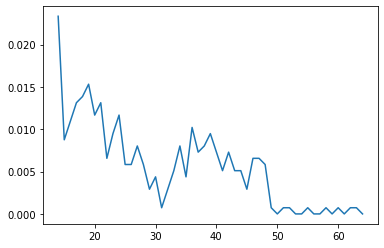

In [138]:
#plt.hist(ins_data["charges"][ins_data["charges"]>13000], group)
total2=len(ins_data["charges"][ins_data["charges"]>13000])
ans2 = []
for i in range(14,65):
    num=len(ins_data["charges"][ins_data["charges"]<(i+1)*1000][ins_data["charges"]>=i*1000])
    ans2.append(num/total)
ans2=np.array(ans2)
plt.plot(range(14,65),ans2)
plt.show()

Now this data can be fed into a new `setup` but this time declaring `test_data` as the test data that was created earlier. 

So there is a combination of **synthetic and real data in the training set** but only real in the test data.

In [139]:
# Run pycaret setup w/synthetic data
setup(data = mixed, 
      target = "charges", 
      test_data = test,
      train_size = 0.7, 
      numeric_features = cont_feats,
      categorical_features = cat_feats,
      ordinal_features = ord_feats,
      normalize_method = "zscore",
      ignore_low_variance = True,
      silent = True, verbose = False)

(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['region', 'smoker',
                                                             'sex'],
                                       display_types=False, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=['age', 'bmi'],
                                       target='charges', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_va...
                 ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                 ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                 ('cluster_all', 'passthrough'),
                 ('dummy', Dummify(target='charges')),
                 ('fix_perf

Now setup the `compare_models` can be checked again. Interestingly the `AUC`, `Recall` and `Precision` all went up considerably. `Recall` nearly doubled!

In [140]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,10691.8116,163989642.4110,11967.4912,-4.7383,0.7712,1.0433,0.0090
br,Bayesian Ridge,9606.2987,140372585.2364,10887.2242,-5.6686,0.7157,0.8208,0.0100
llar,Lasso Least Angle Regression,9604.7642,140284192.7729,10873.9391,-5.6904,0.7150,0.8194,0.0100
ridge,Ridge Regression,9594.5931,140226915.8624,10877.3114,-5.6992,0.7148,0.8170,0.0120
lasso,Lasso Regression,9592.2114,140224691.2266,10876.1062,-5.7135,0.7147,0.8159,0.2190
lr,Linear Regression,9591.8505,140227192.9022,10876.0898,-5.7144,0.7148,0.8159,0.5300
lar,Least Angle Regression,9591.8505,140227192.9022,10876.0898,-5.7144,0.7148,0.8159,0.0090
ada,AdaBoost Regressor,10775.5645,156751486.1141,11978.4084,-5.7934,0.8013,1.1799,0.0200
omp,Orthogonal Matching Pursuit,11663.0700,202151265.0960,12861.9906,-6.0356,0.8842,1.3482,0.0120
huber,Huber Regressor,9302.9543,144291656.1569,10646.8190,-6.6168,0.7275,0.7022,0.0170


ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=6771, selection='cyclic', tol=0.0001, warm_start=False)

A gradient boosting classifier was decided upon.

In [141]:
par = create_model("par")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,10954.8805,143387712.5698,11974.4608,0.1995,0.9926,1.6671
1,9159.9032,103898711.5317,10193.0717,0.2458,0.8758,1.3109
2,8642.4571,98509753.0295,9925.2080,0.1533,0.8381,1.1994
3,6037.1063,98821511.4717,9940.9009,0.1665,0.6844,0.5700
4,5841.8495,122188292.2400,11053.8813,0.2626,0.6121,0.3460
5,7272.8044,130572913.1729,11426.8505,-0.0651,1.0492,0.6452
6,9428.8647,109644020.8651,10471.1041,-24.0453,1.4358,0.5739
7,11221.1583,160140846.3472,12654.6769,-28.1558,1.2325,0.4962
8,14925.8786,263586325.6491,16235.3419,-25.3092,0.7947,0.4559
9,24723.0391,677586546.7186,26030.4926,-15.9813,0.9026,0.5400


In [142]:
final_gbc = finalize_model(huber)

NameError: name 'huber' is not defined

**NOTE**: I haven't further explored the model e.g. feature importance as the purpose of this project was to focus on synthetic data generation and a streamlit app.

# **Saving and exporting ready for app build**
To use the model in a `streamlit` app certain things need to be exported
* The model
* Preprocessed data
* Preparation steps (`prep pipe`)

In [ ]:
# Model (save)
save_model(final_gbc, "final_gbc")

# Preparation steps (get + save)
prep = get_config("prep_pipe")
joblib.dump(prep, 'prep_pipe.pkl', compress = 1)

# Preprocessed data (get + save)
get_config("X").to_csv("preprocssed_data.csv", index = False)

# **Streamlit app**
The final output of this was a `streamlit` app to allow single predictions w/reason plots or multi predictions from an uploaded csv (see `README.md` and `app.py`).

# **Conclusion**
I think that synthetic data generation can be a powerful tool especially in situations when further data collection cannot be performed in the near term. Fine tuning hyperparameters is great to have but more data and feature engineering are still superior.

In [227]:
# any random test
import random
# give a data of 20% 0-100, 40% 100-200, 30% 200-300,10% 300-400, 
small=[[100*random.random()] for _ in range (400)]
medium=[[100+100*random.random()] for _ in range (800)]
large=[[200+100*random.random()] for _ in range (600)]
extralarge=[[300+100*random.random()] for _ in range (200)]
mix=small+medium+large+extralarge
random.shuffle(mix)
df = pd.DataFrame(mix, columns=["s"])
final_ans=[]
for _ in range (200):
    toy_ans = list()
    model = GaussianCopula()
    model.fit(df)
    synth = model.sample(num_rows = 2000)
    for i in range(4):
        num=len(synth["s"][synth["s"]<(i+1)*100][synth["s"]>=i*100])
        toy_ans.append(num/2000)
    final_ans.append(toy_ans)
final_ans

[[0.158, 0.368, 0.332, 0.098],
 [0.168, 0.381, 0.316, 0.096],
 [0.1855, 0.399, 0.281, 0.0925],
 [0.1775, 0.4065, 0.286, 0.0885],
 [0.1715, 0.389, 0.3015, 0.096],
 [0.176, 0.3845, 0.3055, 0.0865],
 [0.1775, 0.3865, 0.3105, 0.0925],
 [0.1695, 0.3715, 0.3185, 0.099],
 [0.158, 0.401, 0.3055, 0.0955],
 [0.178, 0.3735, 0.323, 0.0795],
 [0.1555, 0.3785, 0.3225, 0.095],
 [0.1595, 0.387, 0.324, 0.092],
 [0.174, 0.3695, 0.3295, 0.0855],
 [0.177, 0.379, 0.32, 0.088],
 [0.18, 0.3675, 0.32, 0.09],
 [0.1685, 0.379, 0.308, 0.098],
 [0.178, 0.4005, 0.302, 0.082],
 [0.1715, 0.38, 0.3265, 0.091],
 [0.1915, 0.371, 0.3045, 0.0915],
 [0.1695, 0.3805, 0.311, 0.099],
 [0.179, 0.369, 0.312, 0.0995],
 [0.172, 0.372, 0.319, 0.103],
 [0.1605, 0.393, 0.3165, 0.091],
 [0.171, 0.3835, 0.3065, 0.0945],
 [0.1665, 0.39, 0.302, 0.099],
 [0.182, 0.3625, 0.324, 0.0885],
 [0.1685, 0.393, 0.3055, 0.095],
 [0.17, 0.3895, 0.305, 0.0925],
 [0.1725, 0.3965, 0.308, 0.0835],
 [0.1745, 0.398, 0.3025, 0.0895],
 [0.16, 0.3895, 0.31

(array([49., 43., 43., 36., 37., 42., 33., 47., 43., 27., 75., 83., 88.,
        69., 80., 87., 77., 83., 87., 71., 67., 52., 56., 49., 66., 70.,
        63., 47., 71., 59., 19., 24., 22., 12., 18., 26., 23., 19., 15.,
        22.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
        260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
        390, 400]),
 <a list of 40 Patch objects>)

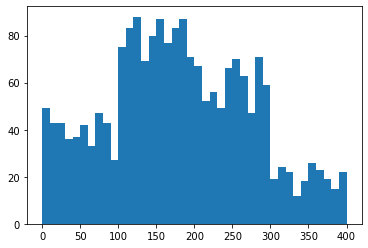

In [239]:
plt.hist(np.array(mix),bins=np.array([10*i for i in range(41)]))

(array([ 0.,  2.,  5.,  6.,  6., 14., 22., 28., 24., 22., 20., 20., 15.,
        10.,  2.,  3.]),
 array([0.076, 0.078, 0.08 , 0.082, 0.084, 0.086, 0.088, 0.09 , 0.092,
        0.094, 0.096, 0.098, 0.1  , 0.102, 0.104, 0.106, 0.108]),
 <a list of 16 Patch objects>)

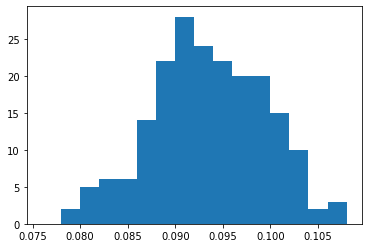

In [244]:
arr=np.array(final_ans)
trans_arr=np.transpose(arr)
plt.hist(trans_arr[3],bins=np.array([i/500 for i in range (38,55)]))

(array([ 1.,  1.,  0.,  3.,  0.,  2.,  3.,  5.,  5.,  9., 10., 11., 14.,
        11., 15., 19., 11., 13., 12.,  9.,  9., 12., 11.,  3.,  4.,  3.,
         3.,  1.]),
 array([0.28 , 0.282, 0.284, 0.286, 0.288, 0.29 , 0.292, 0.294, 0.296,
        0.298, 0.3  , 0.302, 0.304, 0.306, 0.308, 0.31 , 0.312, 0.314,
        0.316, 0.318, 0.32 , 0.322, 0.324, 0.326, 0.328, 0.33 , 0.332,
        0.334, 0.336]),
 <a list of 28 Patch objects>)

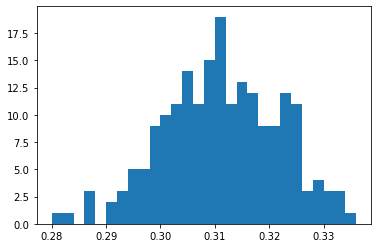

In [254]:
plt.hist(trans_arr[2],bins=np.array([i/500 for i in range (140,169)]))

(array([ 2.,  3.,  4.,  1.,  4.,  7.,  4., 10.,  5., 12., 18., 11., 14.,
        12., 19., 14., 11.,  7.,  8.,  8.,  9.,  7.,  5.,  2.,  2.,  0.,
         1.]),
 array([0.358, 0.36 , 0.362, 0.364, 0.366, 0.368, 0.37 , 0.372, 0.374,
        0.376, 0.378, 0.38 , 0.382, 0.384, 0.386, 0.388, 0.39 , 0.392,
        0.394, 0.396, 0.398, 0.4  , 0.402, 0.404, 0.406, 0.408, 0.41 ,
        0.412]),
 <a list of 27 Patch objects>)

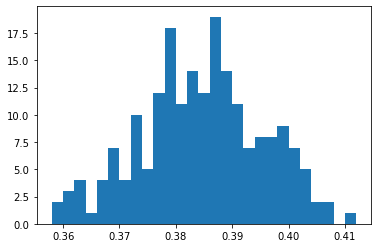

In [263]:
plt.hist(trans_arr[1],bins=np.array([i/500 for i in range (179,207)]))

(array([ 1.,  1.,  4.,  6.,  8., 13., 11.,  3., 11., 16., 18., 20., 16.,
        23., 17.,  9., 10.,  4.,  3.,  3.,  2.,  0.,  1.]),
 array([0.15 , 0.152, 0.154, 0.156, 0.158, 0.16 , 0.162, 0.164, 0.166,
        0.168, 0.17 , 0.172, 0.174, 0.176, 0.178, 0.18 , 0.182, 0.184,
        0.186, 0.188, 0.19 , 0.192, 0.194, 0.196]),
 <a list of 23 Patch objects>)

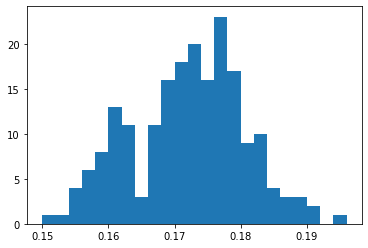

In [267]:
plt.hist(trans_arr[0],bins=np.array([i/500 for i in range (75,99)]))